# 정보검색 2차 과제

### 2012210046 박지홍

#### 목표
Text8 data를 이용해 Word2Vec CBOW model을 구현한다. 16개의 단어를 선택한 후, 각각의 단어와 가장 가까운 4개의 단어를 출력한다.

In [1]:
import collections
import math
import random
import numpy as np
import tensorflow as tf
import sg_util
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
filename=sg_util.maybe_download('','text8.zip', 31344016)
words = sg_util.read_data(filename)
print('Data size', len(words))

vocabulary_size = 50000
data, count, dictionary, reverse_dictionary = sg_util.build_dataset(words,vocabulary_size)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

veryfied
Data size 17005207
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [3]:
del(words)
data_index = 0

In [4]:
def generate_batch(batch_size, skip_window, data_index):
    batch = np.ndarray(shape=(batch_size, 2*skip_window), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # 아무것도 안들어있는 deque를 생성
    generated_batch = 0
    while True:
        if data_index + span > len(data):  # data의 길이에 끝에 다다르면 data의 첫지점으로 되돌아감
            data_index = 0
        for _ in range(span):  # span만큼 deque에 삽입
            buffer.append(data[data_index])
            data_index = data_index + 1
        data_index = data_index - span + 1  # data index를 원래대로 돌려놓고, 한칸 움직임
        # skip window 만큼 buffer에서 leftpop temp_batch에 저장
        temp_batch =[]
        for i in range(skip_window):
            temp_batch.append(buffer.popleft())
        # buffer의 중간 단어를 label에 저장
        labels[generated_batch] = buffer.popleft()
        # skip window 만큼 buffer에서 leftpop temp_batch에 저장
        for i in range(skip_window):
            temp_batch.append(buffer.popleft())    
        batch[generated_batch] = temp_batch
        generated_batch += 1

        if generated_batch == batch_size:
            break
    return batch, labels, data_index


batch, labels, data_index = generate_batch(batch_size=8, skip_window=2, data_index=0)
skip_window = 2
print('skip_window = %d:' % (skip_window))
print('    batch:', [[reverse_dictionary[i] for i in bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])




skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [11]:
batch_size = 128
embedding_size = 128 
skip_window = 2 

valid_size = 16 
valid_window = 100 
valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
num_sampled = 64 

train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Variables.
# embedding, vector for each word in the vocabulary
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

embeds = None
for i in range(2*skip_window):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
    print('embedding %d shape: %s'%(i,embedding_i.get_shape().as_list()))
    emb_x,emb_y = embedding_i.get_shape().as_list()
    if embeds is None:
        embeds = tf.reshape(embedding_i,[emb_x,emb_y,1])
    else:
        embeds = tf.concat([embeds,tf.reshape(embedding_i,[emb_x,emb_y,1])],2)

assert embeds.get_shape().as_list()[2]==2*skip_window
print("Concat embedding size: %s"%embeds.get_shape().as_list())
avg_embed =  tf.reduce_mean(embeds,2,keep_dims=False)
print("Avg embedding size: %s"%avg_embed.get_shape().as_list())

#     loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases,
#                                train_labels,  avg_embed, num_sampled, vocabulary_size))

loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases,
                               train_labels,  avg_embed, num_sampled, vocabulary_size))

# optimizer = tf.train.AdadeltaOptimizer(1.0).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
embedding 2 shape: [128, 128]
embedding 3 shape: [128, 128]
Concat embedding size: [128, 128, 4]
Avg embedding size: [128, 128]


In [12]:
n_iteration = 100001
all_loss = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    average_loss = 0
    data_index = 0
    step = 0
    norm_embed = None
    for epoch in range(n_iteration):
        step += 1
        batch_data, batch_labels, data_index = generate_batch(batch_size, skip_window, data_index)
        _, l = sess.run([optimizer, loss], feed_dict={train_dataset : batch_data, train_labels : batch_labels})
        average_loss += l

        if step % 10000 == 0:
            average_loss /= 10000
            print('average loss at step ' + str(step) + ': ' + str(average_loss) + ' epoch is ' + str(epoch))
            norm_embed = sg_util.closest_words(sess, embeddings.eval(), reverse_dictionary, valid_examples)
            all_loss.append(average_loss)
            average_loss = 0
    final_embeddings = norm_embed.eval()

average loss at step 10000: 43.0041556539 epoch is 9999
nearests to  five  : approximant, zero, ada, austin, 
nearests to  during  : alfred, ada, with, metal, 
nearests to  used  : ada, el, autism, briefly, 
nearests to  states  : roman, grain, austin, behavior, 
nearests to  on  : in, when, that, between, 
nearests to  six  : nine, o, aberdeen, three, 
nearests to  when  : meaning, ada, austin, on, 
nearests to  see  : usa, actor, white, ada, 
nearests to  prince  : ada, for, anarchists, company, 
nearests to  quite  : large, assembly, free, ada, 
nearests to  san  : evidence, usa, process, control, 
nearests to  centre  : image, after, containing, use, 
nearests to  event  : project, wherein, occurring, television, 
nearests to  engine  : service, usa, her, ada, 
nearests to  assembly  : richard, frank, ada, set, 
nearests to  rise  : alfred, singer, regular, austria, 
average loss at step 20000: 8.75398687031 epoch is 19999
nearests to  five  : eight, seven, nine, ada, 
nearests to 

average loss at step 100000: 4.32691044328 epoch is 99999
nearests to  five  : four, seven, three, six, 
nearests to  during  : throughout, in, despite, against, 
nearests to  used  : understood, performed, denoted, considered, 
nearests to  states  : kingdom, nations, grain, speeches, 
nearests to  on  : upon, doubling, principally, observational, 
nearests to  six  : seven, four, eight, three, 
nearests to  when  : if, although, where, once, 
nearests to  see  : gerry, anglicans, gia, brings, 
nearests to  prince  : fourier, associates, company, squid, 
nearests to  quite  : humans, antipope, large, assembly, 
nearests to  san  : bernhard, silence, elevated, physicist, 
nearests to  centre  : credited, bison, image, myth, 
nearests to  event  : occurring, project, deposition, clouds, 
nearests to  engine  : suburbs, anchor, comparative, enzymes, 
nearests to  assembly  : aramaeans, platforms, decibels, neil, 
nearests to  rise  : uae, ha, victor, adjacent, 


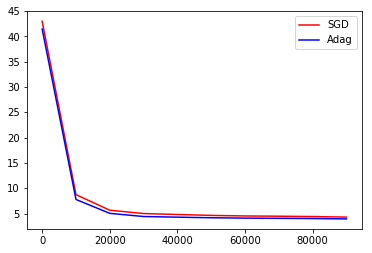

[43.00415565388203, 8.7539868703126906, 5.6850454499602314, 5.026756663072109, 4.8382402758598326, 4.6601261172890664, 4.549990691614151, 4.5022048572540285, 4.4293401380062107, 4.3269104432821273]
[41.464829725313187, 7.8078514593166402, 5.0634254915501407, 4.4400311124513845, 4.3126002806009067, 4.1958385584499203, 4.1228775109159725, 4.082989119878663, 4.0453593855046623, 3.9665323323500647]


In [16]:
t = np.arange(0., 100000, 10000)

sgd, = pylab.plot(t, all_loss, 'r', label='SGD')
adag, = pylab.plot(t, all_loss_adg, 'b', label='adag')
pylab.legend([sgd,adag],['SGD','Adag'])
pylab.show()

print(all_loss)
print(all_loss_adg)

In [7]:
loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases,
                               train_labels,  avg_embed, num_sampled, vocabulary_size))
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

In [8]:
n_iteration = 100001
all_loss_adg = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    average_loss = 0
    data_index = 0
    step = 0
    norm_embed = None
    for epoch in range(n_iteration):
        step += 1
        batch_data, batch_labels, data_index = generate_batch(batch_size, skip_window, data_index)
        _, l = sess.run([optimizer, loss], feed_dict={train_dataset : batch_data, train_labels : batch_labels})
        average_loss += l

        if step % 10000 == 0:
            average_loss /= 10000
            print('average loss at step ' + str(step) + ': ' + str(average_loss) + ' epoch is ' + str(epoch))
            norm_embed = sg_util.closest_words(sess, embeddings.eval(), reverse_dictionary, valid_examples)
            all_loss_adg.append(average_loss)
            average_loss_adg = 0
    final_embeddings = norm_embed.eval()

average loss at step 10000: 41.4648297253 epoch is 9999
nearests to  however  : awards, commited, jacobi, satisfying, 
nearests to  this  : the, reginae, pelvis, its, 
nearests to  on  : psychoanalysis, under, introduced, optimistic, 
nearests to  between  : nose, ada, operatorname, cancer, 
nearests to  over  : toxic, strike, ceremony, before, 
nearests to  of  : poirot, during, for, augustin, 
nearests to  no  : endogenous, linemen, david, neo, 
nearests to  so  : spectrum, apes, agouti, resist, 
nearests to  recorded  : bishop, kingfisher, infant, carta, 
nearests to  instance  : alkanes, business, circ, follow, 
nearests to  dr  : preferred, y, prior, trinitarian, 
nearests to  egypt  : persian, agassiz, drop, meanwhile, 
nearests to  rise  : meaning, configuration, barley, bce, 
nearests to  smith  : miracle, ida, licinius, taoism, 
nearests to  engineering  : involved, street, quotes, marie, 
nearests to  hold  : trench, apatosaurus, proteins, hubbard, 
average loss at step 20000

average loss at step 100000: 3.96653233235 epoch is 99999
nearests to  however  : although, but, though, while, 
nearests to  this  : which, what, it, another, 
nearests to  on  : upon, through, immutable, along, 
nearests to  between  : among, with, within, adverbs, 
nearests to  over  : within, throughout, before, across, 
nearests to  of  : represents, nrsv, regretted, tors, 
nearests to  no  : any, disabilities, little, another, 
nearests to  so  : too, tail, actually, particles, 
nearests to  recorded  : released, performed, developed, lodged, 
nearests to  instance  : example, reasons, except, purposes, 
nearests to  dr  : robert, sir, richard, drava, 
nearests to  egypt  : israel, persian, afghanistan, wessex, 
nearests to  rise  : azad, relocated, existing, lamanites, 
nearests to  smith  : charles, andrew, preclear, samuel, 
nearests to  engineering  : research, art, development, electronic, 
nearests to  hold  : ask, follow, allow, say, 


In [17]:
optimizer = tf.train.AdadeltaOptimizer(1.0).minimize(loss)

In [18]:
n_iteration = 100001
all_loss_add = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    average_loss = 0
    data_index = 0
    step = 0
    norm_embed = None
    for epoch in range(n_iteration):
        step += 1
        batch_data, batch_labels, data_index = generate_batch(batch_size, skip_window, data_index)
        _, l = sess.run([optimizer, loss], feed_dict={train_dataset : batch_data, train_labels : batch_labels})
        average_loss += l

        if step % 10000 == 0:
            average_loss /= 10000
            print('average loss at step ' + str(step) + ': ' + str(average_loss) + ' epoch is ' + str(epoch))
            norm_embed = sg_util.closest_words(sess, embeddings.eval(), reverse_dictionary, valid_examples)
            all_loss_add.append(average_loss)
            average_loss_add = 0
    final_embeddings = norm_embed.eval()

average loss at step 10000: 219.612200539 epoch is 9999
nearests to  five  : a, the, and, of, 
nearests to  during  : one, by, is, with, 
nearests to  used  : zero, of, in, s, 
nearests to  states  : invaders, one, numeric, zero, 
nearests to  on  : to, of, the, a, 
nearests to  six  : the, a, and, one, 
nearests to  when  : of, that, on, the, 
nearests to  see  : a, of, seven, in, 
nearests to  prince  : tirthankaras, ffff, more, centro, 
nearests to  quite  : lavoisier, authority, tui, wafers, 
nearests to  san  : chiropractors, eagles, recovered, autocracy, 
nearests to  centre  : sticking, mitre, oxygen, stockton, 
nearests to  event  : astronauts, ges, mechanical, characters, 
nearests to  engine  : bowers, gambeson, luigi, wanton, 
nearests to  assembly  : deckard, symptoms, lazarus, set, 
nearests to  rise  : clemens, standout, busman, contra, 
average loss at step 20000: 147.495719625 epoch is 19999
nearests to  five  : a, the, and, by, 
nearests to  during  : one, by, is, with

In [19]:
num_points = 300

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])


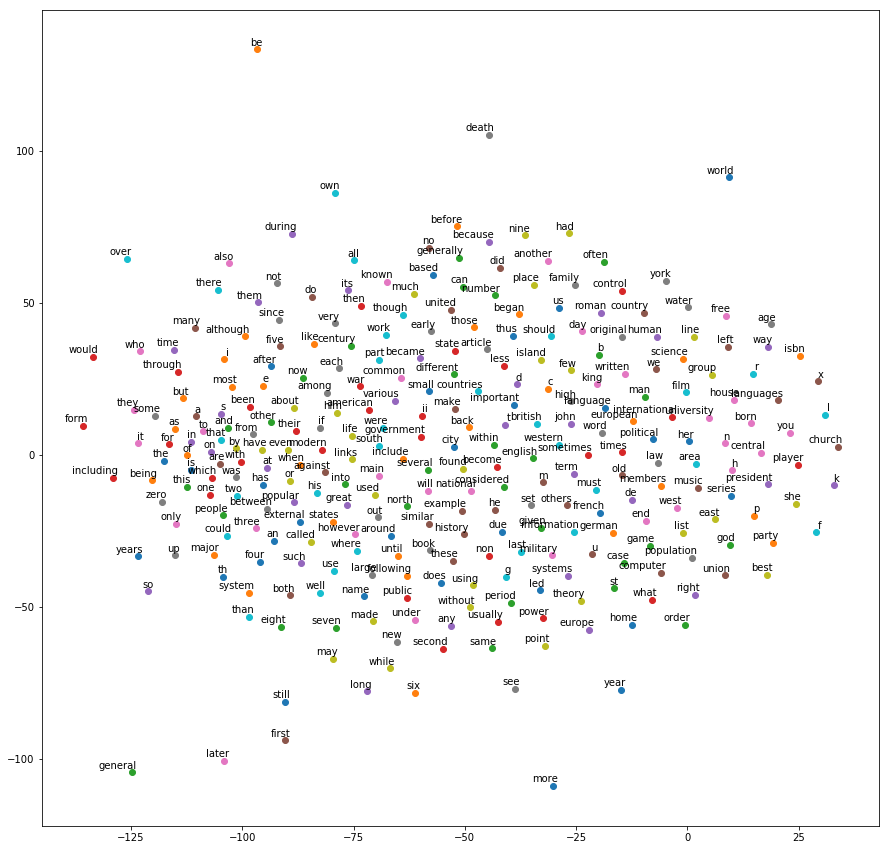

In [20]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)
